In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Load the data
data = pd.read_csv("TCS1.csv")  # Update the path to your CSV file
print("Data loaded successfully.")

Data loaded successfully.


In [3]:
# Display information about the data
print("Data information:")
print(data.info())
print("\nData sample:")
print(data.head())


Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4494 entries, 0 to 4493
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4494 non-null   object 
 1   Open       4486 non-null   float64
 2   High       4486 non-null   float64
 3   Low        4486 non-null   float64
 4   Close      4486 non-null   float64
 5   Adj Close  4486 non-null   float64
 6   Volume     4486 non-null   float64
dtypes: float64(6), object(1)
memory usage: 245.9+ KB
None

Data sample:
         Date        Open        High         Low       Close  Adj Close  \
0  2004-08-27  122.800003  122.800003  119.820000  120.332497  88.088272   
1  2004-08-30  121.237503  123.750000  120.625000  123.345001  90.293549   
2  2004-08-31  123.312500  123.750000  122.000000  123.512497  90.416122   
3  2004-09-01  123.750000  124.375000  122.949997  123.487503  90.397820   
4  2004-09-02  123.737503  125.574997  123.250000  124.207497  

In [4]:
# Handling missing values
print("\nRows with missing values:")
print(data[data.isnull().any(axis=1)])
data = data.dropna()
print("Missing values handled.")



Rows with missing values:
            Date  Open  High  Low  Close  Adj Close  Volume
33    2004-10-13   NaN   NaN  NaN    NaN        NaN     NaN
1349  2010-02-06   NaN   NaN  NaN    NaN        NaN     NaN
1827  2012-01-07   NaN   NaN  NaN    NaN        NaN     NaN
1866  2012-03-03   NaN   NaN  NaN    NaN        NaN     NaN
1996  2012-09-08   NaN   NaN  NaN    NaN        NaN     NaN
2038  2012-11-11   NaN   NaN  NaN    NaN        NaN     NaN
2375  2014-03-22   NaN   NaN  NaN    NaN        NaN     NaN
2604  2015-02-28   NaN   NaN  NaN    NaN        NaN     NaN
Missing values handled.


In [5]:
# Preprocessing
data = data[['Date', 'Close']]
data = data.set_index('Date')

scaler = sklearn.preprocessing.MinMaxScaler()
data = scaler.fit_transform(data)


In [6]:
# Train-test split
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_data, test_data = data[:train_size, :], data[train_size:, :]


In [7]:
# Create dataset for time series prediction
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)
                                     
                                     
time_steps = 10
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print("Data preprocessing complete.")


Data preprocessing complete.


In [8]:
# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(1, time_steps)),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(units=1)
])
print("Model architecture built.")

Model architecture built.


In [9]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
print("Model compilation complete.")


Model compilation complete.


In [10]:
# Learning Curve Analysis
train_sizes = np.linspace(1, len(X_train), 10, dtype=int)
train_errors = []
test_errors = []

print("Starting Learning Curve Analysis...")

for train_size in train_sizes:
    X_subset, y_subset = X_train[:train_size], y_train[:train_size]
    print(f"Training on subset of size: {train_size}")
    
    # Train the model
    model.fit(X_subset, y_subset, epochs=10, batch_size=16, verbose=0)
    print("Model trained.")
    
    # Predict on the training and testing subsets
    train_pred = model.predict(X_subset)
    test_pred = model.predict(X_test[:train_size])
    
    # Calculate errors and handle NaN values
    train_mse = mean_squared_error(y_subset, train_pred)
    test_mse = mean_squared_error(y_test[:train_size], test_pred)
    
    if not np.isnan(train_mse) and not np.isnan(test_mse):
        train_errors.append(train_mse)
        test_errors.append(test_mse)
        print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

print("Learning Curve Analysis complete.")


Starting Learning Curve Analysis...
Training on subset of size: 1
Model trained.
1/1 [==============================] - 0s 47ms/step
Train MSE: 0.0000, Test MSE: 0.2321
Training on subset of size: 398
Model trained.
13/13 [==============================] - 0s 3ms/step
Train MSE: 0.0000, Test MSE: 0.0024
Training on subset of size: 795
Model trained.
25/25 [==============================] - 0s 5ms/step
Train MSE: 0.0000, Test MSE: 0.0132
Training on subset of size: 1193
Model trained.
28/28 [==============================] - 0s 5ms/step
Train MSE: 0.0000, Test MSE: 0.0129
Training on subset of size: 1590
Model trained.
28/28 [==============================] - 0s 5ms/step
Train MSE: 0.0000, Test MSE: 0.0090
Training on subset of size: 1988
Model trained.
28/28 [==============================] - 0s 4ms/step
Train MSE: 0.0000, Test MSE: 0.0118
Training on subset of size: 2385
Model trained.
28/28 [==============================] - 0s 4ms/step
Train MSE: 0.0000, Test MSE: 0.0100
Training on

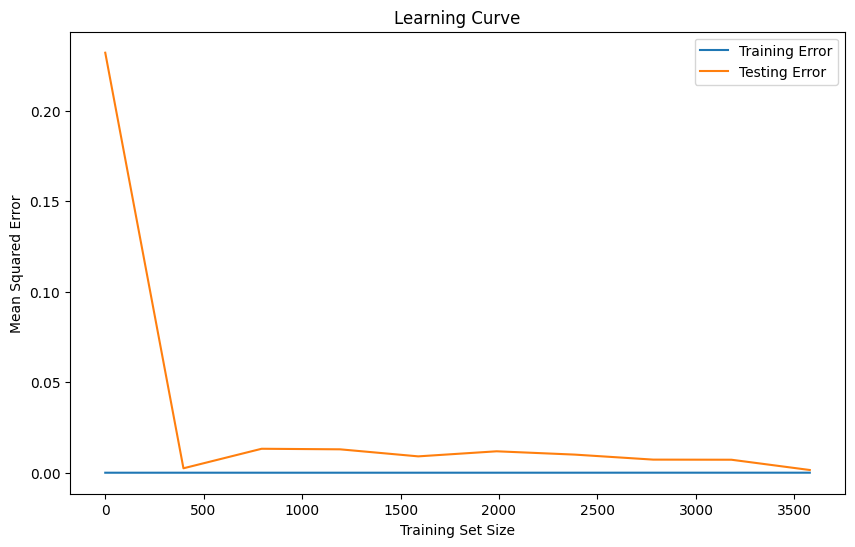

In [11]:
# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training Error')
plt.plot(train_sizes, test_errors, label='Testing Error')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [12]:
# P-value Test
y_test_pred = model.predict(X_test)
p_values = f_regression(y_test_pred, y_test)[1]
print("P-values for predictions:", p_values)


28/28 [==============================] - 0s 4ms/step
P-values for predictions: [0.]


In [13]:
# Set a significance threshold
significance_threshold = 0.05

# Check p-values and make a decision
significant_predictions = np.where(p_values < significance_threshold)[0]
non_significant_predictions = np.where(p_values >= significance_threshold)[0]


for i in significant_predictions:
    print("\nSignificant predictions:")
    print(f"Sample {i+1}: p-value = {p_values[i]:.4f}, Prediction = {y_test_pred[i][0]:.4f}")


for i in non_significant_predictions:
    print("\nNon-significant predictions:")
    print(f"Sample {i+1}: p-value = {p_values[i]:.4f}, Prediction = {y_test_pred[i][0]:.4f}")


Significant predictions:
Sample 1: p-value = 0.0000, Prediction = 0.4877
